In [26]:
import datetime
from pathlib import Path
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import serial

In [2]:
!ls /dev/tty.*

/dev/tty.Bluetooth-Incoming-Port /dev/tty.usbmodem3794661


# Read Arduino data and write csv file

[Python Datalogger - Using pySerial to Read Serial Data Output from Arduino](https://makersportal.com/blog/2018/2/25/python-datalogger-reading-the-serial-output-from-arduino-to-analyze-data-using-pyserial)

## Get 2.5 hours of data in my office

In [22]:
data_directory = Path("data_190730")
max_counts = 9000

datafile = data_directory / "190730_test1.csv"
 
teensy = serial.Serial('/dev/tty.usbmodem3794661', 115200)
time.sleep(0.25)
teensy.flushInput()
time.sleep(0.25)

beginning_of_valid_data_line = "(Addr, TempC, TempF):"

counter = 0
while True:
    if counter < max_counts:
        line = teensy.readline()
        dt = datetime.datetime.now()
        line = line.decode().strip()
        if line.startswith(beginning_of_valid_data_line):
            data = line.strip(beginning_of_valid_data_line).strip().split(";")
            num_temp_sensors = len(data)
            data_string = f"{dt},"
            with open(datafile, "a") as f:
                for i, d in enumerate(data):
                    data_string += d
                    if i == num_temp_sensors - 1:
                        data_string += "\n"
                    else:
                         data_string += ","
                #print("data_string: ", data_string)
                f.write(data_string)
            if counter % 10 == 0:
                print(counter, data_string)
        else:
            print(f"Bad data at counter {counter} and datetime {d}, line is {line}")
        counter += 1
    else:
        break

teensy.close()


0 2019-07-30 14:44:36.102486,0x48,24.4375,75.9875,0x49,24.0625,75.3125,0x4A,23.8750,74.9750,0x4B,23.6250,74.5250

10 2019-07-30 14:44:46.126403,0x48,24.4375,75.9875,0x49,24.1250,75.4250,0x4A,23.8750,74.9750,0x4B,23.6875,74.6375

20 2019-07-30 14:44:56.149449,0x48,24.4375,75.9875,0x49,24.0625,75.3125,0x4A,23.8125,74.8625,0x4B,23.6250,74.5250

30 2019-07-30 14:45:06.173010,0x48,24.3750,75.8750,0x49,24.0625,75.3125,0x4A,23.8125,74.8625,0x4B,23.6250,74.5250

40 2019-07-30 14:45:16.196484,0x48,24.4375,75.9875,0x49,24.1250,75.4250,0x4A,23.8750,74.9750,0x4B,23.6875,74.6375

50 2019-07-30 14:45:26.220196,0x48,24.4375,75.9875,0x49,24.1250,75.4250,0x4A,23.8750,74.9750,0x4B,23.6875,74.6375

60 2019-07-30 14:45:36.242832,0x48,24.5000,76.1000,0x49,24.1250,75.4250,0x4A,23.8750,74.9750,0x4B,23.6875,74.6375

70 2019-07-30 14:45:46.267181,0x48,24.5000,76.1000,0x49,24.1250,75.4250,0x4A,23.8750,74.9750,0x4B,23.7500,74.7500

80 2019-07-30 14:45:56.289677,0x48,24.4375,75.9875,0x49,24.1250,75.4250,0x4A,23.8

# Read csv file

In [28]:
mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")

column_names = [
    'DateTime',
    'Address_1', 'Temp_C_1', 'Temp_F_1',
    'Address_2', 'Temp_C_2', 'Temp_F_2',
    'Address_3', 'Temp_C_3', 'Temp_F_3',
    'Address_4', 'Temp_C_4', 'Temp_F_4',
]

df = pd.read_csv(datafile, sep=',', names=column_names, 
                 parse_dates=['DateTime'], date_parser= mydateparser
                )
df['DeltaTime_s'] = (df['DateTime'] - df['DateTime'][0])/np.timedelta64(1,'s')
df['DeltaTime_min'] = (df['DateTime'] - df['DateTime'][0])/np.timedelta64(1,'m')
df['DeltaTime_hr'] = (df['DateTime'] - df['DateTime'][0])/np.timedelta64(1,'h')
df.head()

,DateTime,Address_1,Temp_C_1,Temp_F_1,Address_2,Temp_C_2,Temp_F_2,Address_3,Temp_C_3,Temp_F_3,Address_4,Temp_C_4,Temp_F_4,DeltaTime_s,DeltaTime_min,DeltaTime_hr
0,2019-07-30 14:44:36.102486,0x48,24.4375,75.9875,0x49,24.0625,75.3125,0x4A,23.875,74.975,0x4B,23.6250,74.5250,0.000000,0.000000,0.000000
1,2019-07-30 14:44:37.104866,0x48,24.5000,76.1000,0x49,24.1250,75.4250,0x4A,23.875,74.975,0x4B,23.6875,74.6375,1.002380,0.016706,0.000278
2,2019-07-30 14:44:38.107759,0x48,24.4375,75.9875,0x49,24.0625,75.3125,0x4A,23.875,74.975,0x4B,23.6875,74.6375,2.005273,0.033421,0.000557
3,2019-07-30 14:44:39.109167,0x48,24.4375,75.9875,0x49,24.1250,75.4250,0x4A,23.875,74.975,0x4B,23.6250,74.5250,3.006681,0.050111,0.000835
4,2019-07-30 14:44:40.111331,0x48,24.5000,76.1000,0x49,24.1250,75.4250,0x4A,23.875,74.975,0x4B,23.6875,74.6375,4.008845,0.066814,0.001114


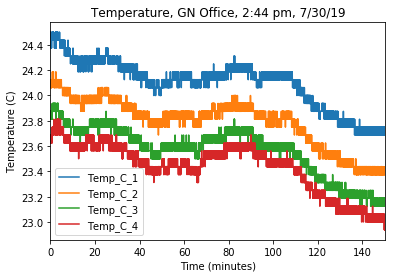

In [36]:
ax = df.plot.line(x='DeltaTime_min', y=['Temp_C_1', 'Temp_C_2', 'Temp_C_3', 'Temp_C_4'], figsize=(6,4))
ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Temperature (C)")
ax.set_title("Temperature, GN Office, 2:44 pm, 7/30/19")
plt.savefig(data_directory / "190730_office_temperature.png")